#**Prediksi Suhu Global**

Pemanasan global adalah fenomena peningkatan suhu rata-rata atmosfer, laut, dan daratan Bumi. Dalam proyek ini, kita akan mencoba memahami bagaimana suhu global telah berubah dari masa lalu hingga sekarang. Kita akan menggunakan dataset yang berisi catatan historis suhu global dan menerapkan model prediktif untuk memahami tren suhu di masa mendatang.

Dataset yang digunakan dalam proyek ini berisi catatan suhu global harian dalam format CSV. Kolom `dt` berisi tanggal pengamatan, dan kolom `LandAndOceanAverageTemperature` berisi suhu rata-rata global pada tanggal tersebut.

Dengan menggunakan teknik pemodelan prediktif seperti LSTM (Long Short-Term Memory), kita dapat melihat bagaimana suhu global telah berubah sepanjang waktu dan membuat prediksi tentang bagaimana suhu mungkin berubah di masa mendatang. Hasil ini dapat memberikan wawasan berharga tentang pemanasan global dan dampaknya terhadap iklim kita. 😊

## **Import Library yang dibutuhkan**
Di sini dibutuhkan library yang biasa dipakai seperti pandas, numpy, matplotlib, keras dan sklearn.

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.dates as mdates
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.metrics import MeanAbsoluteError

from sklearn.linear_model import LinearRegression

# **Mounting Google Drive dan Loading File**

File bernama GlobalTemperatures.csv dimuat ke dalam Google Colab.

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
# Tentukan path file
file_path = '/content/drive/MyDrive/Bangkit Academy/ML Terapan Dicoding/GlobalTemperatures.csv'

# Baca file csv menggunakan pandas
import pandas as pd
data = pd.read_csv(file_path)

# Tampilkan data
print(data.head())

           dt  LandAverageTemperature  LandAverageTemperatureUncertainty  \
0  1750-01-01                   3.034                              3.574   
1  1750-02-01                   3.083                              3.702   
2  1750-03-01                   5.626                              3.076   
3  1750-04-01                   8.490                              2.451   
4  1750-05-01                  11.573                              2.072   

   LandMaxTemperature  LandMaxTemperatureUncertainty  LandMinTemperature  \
0                 NaN                            NaN                 NaN   
1                 NaN                            NaN                 NaN   
2                 NaN                            NaN                 NaN   
3                 NaN                            NaN                 NaN   
4                 NaN                            NaN                 NaN   

   LandMinTemperatureUncertainty  LandAndOceanAverageTemperature  \
0                 

## **Menyeleksi kolom dan baris yang perlu**
Kolom dt sebagai tanggal dan kolom LandAndOceanAverageTemperature sebagai kolom yang memberikan suhu rata-rata dunia. Dan Suhu rata-rata dunia ini dimulai pada tanggal 1 Januari 1850 sehingga perlu dilakukan penyeleksian data mulai dari baris ke-1200.

In [32]:
# Pilih kolom 'dt' dan 'LandAndOceanAverageTemperature' serta baris dari indeks 1200 sampai ke bawah
data_modified = data.loc[1200:, ['dt', 'LandAndOceanAverageTemperature']]

# Tampilkan data yang telah dimodifikasi
print(data_modified.head())

              dt  LandAndOceanAverageTemperature
1200  1850-01-01                          12.833
1201  1850-02-01                          13.588
1202  1850-03-01                          14.043
1203  1850-04-01                          14.667
1204  1850-05-01                          15.507


#**Training dan Testing Model**

* Sebelum melakukan training kita normalisasi terlebih dahulu dataset sehingga dapat dengan lebih cepat diproses.
* Kita membuat timestep sebanyak 12 yang artinya 12 data sebelumnya digunakan untuk memprediksi suhu pada data ke-13 dan seterusnya.
* Lalu reshape input
* Kompilasi suatu model LSTM, latih dan evaluasi model tersebut. Dalam hal ini akurasi menggunakan Mean Absolute Error.

In [54]:
import keras

# Ubah DataFrame menjadi array numpy
data_array = data_modified['LandAndOceanAverageTemperature'].values.reshape(-1,1)

# Normalisasi data
scaler = MinMaxScaler(feature_range=(0,1))
data_normalized = scaler.fit_transform(data_array)

# Bagi data menjadi data training dan testing
train_data, test_data = train_test_split(data_normalized, test_size=0.2, shuffle=False)

# Fungsi untuk membuat dataset untuk LSTM
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Buat dataset untuk LSTM
look_back = 12
trainX, trainY = create_dataset(train_data, look_back)
testX, testY = create_dataset(test_data, look_back)

# Reshape input untuk menjadi [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Buat dan kompilasi model LSTM
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(8))  # Tambahkan lapisan Dense dengan 8 unit
model.add(keras.layers.Reshape((1, 8)))  # Reshape output dari lapisan Dense untuk menjadi input lapisan LSTM
model.add(LSTM(4))  # Tambahkan lapisan LSTM dengan 4 unit di antara dua lapisan Dense
model.add(Dense(1))  # Lapisan output
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=[MeanAbsoluteError()])

# Latih model
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

# Evaluasi model
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MAE' % (trainScore[0]))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MAE' % (testScore[0]))

Epoch 1/100
1580/1580 - 10s - loss: 0.0676 - mean_absolute_error: 0.0676 - 10s/epoch - 7ms/step
Epoch 2/100
1580/1580 - 4s - loss: 0.0292 - mean_absolute_error: 0.0292 - 4s/epoch - 3ms/step
Epoch 3/100
1580/1580 - 5s - loss: 0.0283 - mean_absolute_error: 0.0283 - 5s/epoch - 3ms/step
Epoch 4/100
1580/1580 - 4s - loss: 0.0276 - mean_absolute_error: 0.0276 - 4s/epoch - 3ms/step
Epoch 5/100
1580/1580 - 5s - loss: 0.0270 - mean_absolute_error: 0.0270 - 5s/epoch - 3ms/step
Epoch 6/100
1580/1580 - 5s - loss: 0.0266 - mean_absolute_error: 0.0266 - 5s/epoch - 3ms/step
Epoch 7/100
1580/1580 - 4s - loss: 0.0258 - mean_absolute_error: 0.0258 - 4s/epoch - 3ms/step
Epoch 8/100
1580/1580 - 5s - loss: 0.0263 - mean_absolute_error: 0.0263 - 5s/epoch - 3ms/step
Epoch 9/100
1580/1580 - 4s - loss: 0.0255 - mean_absolute_error: 0.0255 - 4s/epoch - 3ms/step
Epoch 10/100
1580/1580 - 4s - loss: 0.0249 - mean_absolute_error: 0.0249 - 4s/epoch - 3ms/step
Epoch 11/100
1580/1580 - 5s - loss: 0.0248 - mean_absolut

## **Visualisasi Data**

Di sini disajikan perbandingan data real dan prediksi data yang menggunakan model LSTM.

13/13 [==============================] - 0s 2ms/step


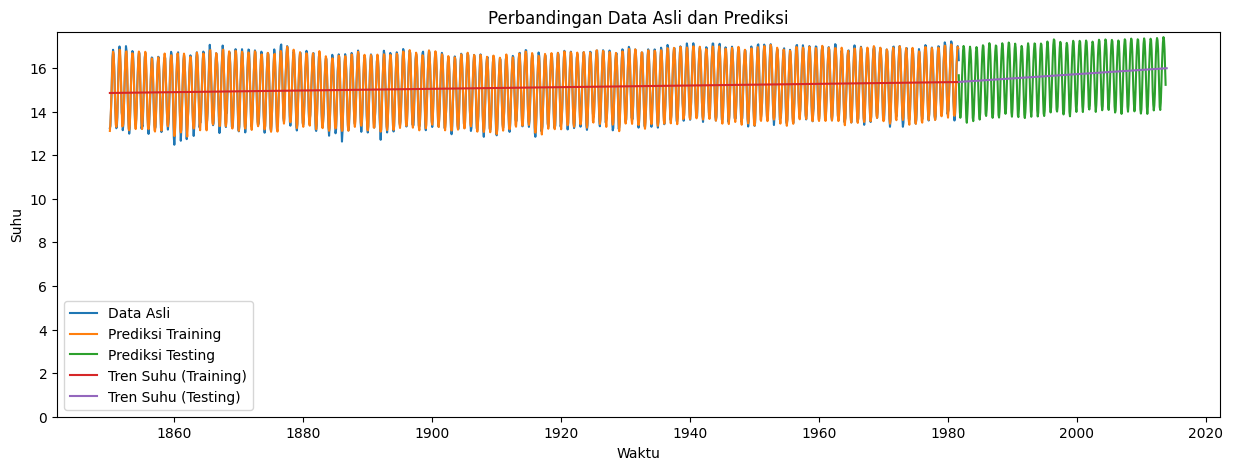

In [48]:
# Prediksi data training dan testing
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Balikkan normalisasi
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(train_data[look_back:])  # Gunakan data asli yang telah dinormalisasi
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(test_data[look_back:])  # Gunakan data asli yang telah dinormalisasi

# Buat vektor waktu berdasarkan kolom 'dt'
time_vector = pd.to_datetime(data_modified['dt'])

# Plot data asli
plt.figure(figsize=(15, 5))
plt.plot(time_vector[:len(trainY)], trainY, label='Data Asli')

# Plot prediksi training
plt.plot(time_vector[:len(trainPredict)], trainPredict, label='Prediksi Training')

# Plot prediksi testing
plt.plot(time_vector[len(trainPredict):len(trainPredict)+len(testPredict)], testPredict, label='Prediksi Testing')

# Lakukan regresi linier pada data asli
model_reg_train = LinearRegression()
model_reg_train.fit(np.arange(len(trainY)).reshape(-1, 1), trainY)

model_reg_test = LinearRegression()
model_reg_test.fit(np.arange(len(testY)).reshape(-1, 1), testY)

# Tambahkan garis regresi ke plot
plt.plot(time_vector[:len(trainY)], model_reg_train.predict(np.arange(len(trainY)).reshape(-1, 1)), label='Tren Suhu (Training)')
plt.plot(time_vector[len(trainY):len(trainY)+len(testY)], model_reg_test.predict(np.arange(len(testY)).reshape(-1, 1)), label='Tren Suhu (Testing)')

plt.xlabel('Waktu')
plt.ylabel('Suhu')
plt.title('Perbandingan Data Asli dan Prediksi')
plt.legend()

# Atur batas bawah sumbu y menjadi 0
plt.ylim(bottom=0)

plt.show()


Dan di bagian akhir ditunjukkan plot prediksi dari model yang sudah dilatih untuk 50 tahun ke depannya.

1/1 [==============================] - 0s 38ms/step
Prediksi Suhu Global untuk 50 Tahun ke Depan:
Tahun 2024: 14.33 derajat Celsius
Tahun 2025: 14.47 derajat Celsius
Tahun 2026: 15.01 derajat Celsius
Tahun 2027: 15.75 derajat Celsius
Tahun 2028: 16.43 derajat Celsius
Tahun 2029: 16.98 derajat Celsius
Tahun 2030: 17.29 derajat Celsius
Tahun 2031: 17.24 derajat Celsius
Tahun 2032: 16.86 derajat Celsius
Tahun 2033: 16.20 derajat Celsius


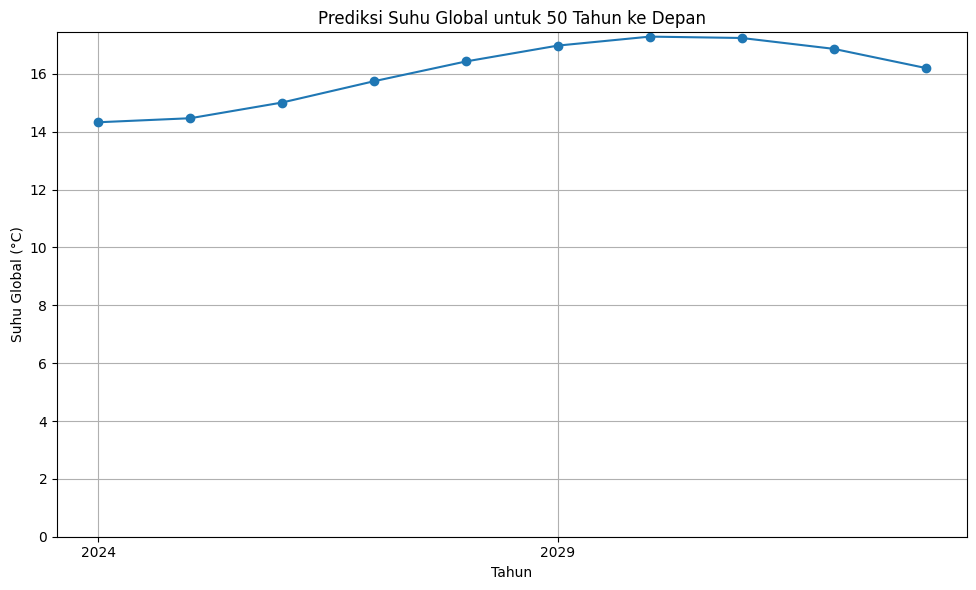

In [58]:
# Fungsi untuk memprediksi suhu global 50 tahun ke depan
def predict_future_temperature(model, initial_data, look_back, years):
    predicted_temperatures = initial_data[-look_back:].reshape(1, -1)

    predictions = []

    for i in range(years):
        last_data = predicted_temperatures[:, -look_back:]
        last_data = last_data.reshape((last_data.shape[0], 1, last_data.shape[1]))
        prediction = model.predict(last_data)
        predictions.append(prediction[0])

        # Update predicted_temperatures for the next iteration
        predicted_temperatures = np.hstack((predicted_temperatures, prediction))

    return predictions

# Prediksi suhu global 50 tahun ke depan
future_years = 10
predicted_temperatures = predict_future_temperature(model, data_normalized, look_back, future_years)

# Denormalisasi hasil prediksi
predicted_temperatures_denormalized = scaler.inverse_transform(np.array(predicted_temperatures).reshape(-1, 1))

# Tampilkan hasil prediksi
print("Prediksi Suhu Global untuk 50 Tahun ke Depan:")
for i in range(len(predicted_temperatures_denormalized)):
    print("Tahun {}: {:.2f} derajat Celsius".format(2024 + i, predicted_temperatures_denormalized[i][0]))

# Tahun-tahun untuk plotting
years = range(2024, 2024 + future_years)

# Plot hasil prediksi
plt.figure(figsize=(10, 6))
plt.plot(years, predicted_temperatures_denormalized, marker='o', linestyle='-')
plt.title('Prediksi Suhu Global untuk 50 Tahun ke Depan')
plt.xlabel('Tahun')
plt.ylabel('Suhu Global (°C)')
plt.grid(True)
plt.xticks(range(2024, 2024 + future_years, 5))  # Atur label sumbu x setiap 5 tahun
plt.tight_layout()

# Atur batas bawah sumbu y menjadi 0
plt.ylim(bottom=0)

plt.show()